# FEATURE ENGINEERING STEPS
- Import data and packages
- Divide dataset into test and train
- Deal with missing values
- Encode and simplify categorical variables
- Log transformations for skewed numerical variables
- Scaling for numerical features
- Handling class imbalance

## <u>Import data and packages</u>

In [1]:
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import numpy as np 
import json
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC




# import data
df_base = pd.read_csv('data/Base.csv') 

# import feature data types
with open('python_scripts/data_types.json') as f:
    data_types = json.load(f) 

# encoding source {'INTERNET', 'TELEAPP'} into source_is_internet_not_teleapp
df_base['source_is_internet_not_teleapp'] = (df_base['source'] == 'INTERNET').astype(int)
df_base.drop('source', axis=1, inplace=True)


# recording which variables have missing values recorded as -1
missing_values = ['prev_address_months_count',
                  'current_address_months_count',
                  'bank_months_count',
                  'session_length_in_minutes',
                  'device_distinct_emails_8w']

## <u>Divide dataset into training set and testing set</u>

In [2]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_base.drop('fraud_bool', axis=1), df_base.fraud_bool, test_size=0.2, random_state=0)


## <u>Deal with missing values</u>
#### Imputation considerations
- Should test set influence median/mode calculations for imputing values? What does the industry say?  
  - **NO.** Because in a real-life setting where you get new data, if you do this you're essentially introducing values into the training set that may not reflect the true relationship between feature X and the target in the training data. This hides/masks the importance of a potential change in the values of feature X and hurts the model's ability to recognize its impact in the new dataset.  
  - In a scenario where the model is being retrained, it should only be done when the new dataset has a target value attached to it too so that the latest importance of features can be measured. Do not use data without target values.  
  - **In this case:** 
    - Since we are splitting a single dataset into train and test, the averages of features are likely to be consistent throughout both datasets. So using overall averages to impute missing values wouldn't necessarily cause any issues. However, if we were to treat the test dataset as completely unseen data (which we should), then we should not use test data to impute missing values in the training set.  
  - **Imputing Missing Values in Test Set**: 
    - If in a real life scenario a whole unseen dataset is provided, missing values in this dataset should only be imputed with averages calculated from this dataset.
    - If in a real life scenario a new instance is dealt with on a case by case basis, any missing values should be imputed with averages calculated from the training set.
    - **In this case:**
      - Imagining that each instance of the test set is an isolated instance, we should just impute missing values with averages calculated from the training set

#### FEATURE: device_distinct_emails_8w 
- impute missing values with mode (since it is categories, dont necessarily want middle value, just the most represented)


In [3]:
# device_distinct_emails_8w - impute missing values with mode (since it is categories, dont necessarily want middle value, just the most represented)
device_distinct_emails_8w_mode = X_train.device_distinct_emails_8w.value_counts().sort_values(ascending=False).index[0]

X_train.loc[X_train.device_distinct_emails_8w == -1, 'device_distinct_emails_8w'] = device_distinct_emails_8w_mode
X_test.loc[X_test.device_distinct_emails_8w == -1, 'device_distinct_emails_8w'] = device_distinct_emails_8w_mode


#### FEATURE: session_length_in_minutes 
- impute missing values with median


In [4]:
# session_length_in_minutes - impute missing values with median
session_length_in_minutes_median_position = int(np.ceil((len(X_train[X_train.session_length_in_minutes != -1])/2)-1))
session_length_in_minutes_median = sorted(X_train[X_train.session_length_in_minutes != -1].session_length_in_minutes)[session_length_in_minutes_median_position]

X_train.loc[X_train.session_length_in_minutes == -1, 'session_length_in_minutes'] = session_length_in_minutes_median
X_test.loc[X_test.session_length_in_minutes == -1, 'session_length_in_minutes'] = session_length_in_minutes_median


#### FEATURE: bank_months_count
- drop feature, create binary feature for value provided or not (more useful indicator)


In [5]:
# drop bank_months_count, create binary feature for value provided or not
X_train['bank_months_count_provided'] = [0 if i == -1 else 1 for i in X_train.bank_months_count]
X_train.drop('bank_months_count', axis=1, inplace=True)

X_test['bank_months_count_provided'] = [0 if i == -1 else 1 for i in X_test.bank_months_count]
X_test.drop('bank_months_count', axis=1, inplace=True)

#### FEATURE: prev_address_months_count
- drop feature (too many missing values), create binary feature for value provided or not


In [6]:
# drop prev_address_months_count (too many missing values), create binary feature for value provided or not
X_train['prev_address_months_count_provided'] = [0 if i == -1 else 1 for i in X_train.prev_address_months_count]
X_train.drop('prev_address_months_count', axis=1, inplace=True)

X_test['prev_address_months_count_provided'] = [0 if i == -1 else 1 for i in X_test.prev_address_months_count]
X_test.drop('prev_address_months_count', axis=1, inplace=True)

#### FEATURE: current_address_months_count 
- impute missing values with median


In [7]:
# current_address_months_count - impute missing values with median
X_train['current_address_months_count_provided'] = [0 if i == -1 else 1 for i in X_train.current_address_months_count]
X_test['current_address_months_count_provided'] = [0 if i == -1 else 1 for i in X_test.current_address_months_count]

# and create binary features for value provided or not

current_address_months_count_median_position = int(np.ceil((len(X_train[X_train['current_address_months_count'] != -1])/2)-1))
current_address_months_count_median = sorted(X_train[X_train['current_address_months_count'] != -1]['current_address_months_count'])[current_address_months_count_median_position]

X_train.loc[X_train['current_address_months_count'] == -1, 'current_address_months_count'] = current_address_months_count_median
X_test.loc[X_test['current_address_months_count'] == -1, 'current_address_months_count'] = current_address_months_count_median

## <u>Encode and simplfy categorical features</u>

In [8]:
# drop device_fraud_count (single value)
X_train.drop('device_fraud_count', axis=1, inplace=True)
X_test.drop('device_fraud_count', axis=1, inplace=True)

In [9]:
# simplying proposed credit limit to 5 categories
categories_to_keep = X_train.proposed_credit_limit.value_counts().index[:4] # taking 4 largest represented proposed limits
X_train['proposed_credit_limit'] = X_train['proposed_credit_limit'].where(X_train['proposed_credit_limit'].isin(categories_to_keep), 'other').astype(str)
X_test['proposed_credit_limit'] = X_test['proposed_credit_limit'].where(X_test['proposed_credit_limit'].isin(categories_to_keep), 'other').astype(str)

In [10]:
# one hot encoding
categories_to_encode = ['proposed_credit_limit', 'payment_type', 'employment_status', 'housing_status', 'device_os']
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first') 
encoded_array = ohe.fit_transform(X_train[categories_to_encode])
encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out())
X_train_encoded = pd.concat([X_train.drop(columns=categories_to_encode).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

encoded_array_test = ohe.transform(X_test[categories_to_encode])
encoded_df_test = pd.DataFrame(encoded_array_test, columns=ohe.get_feature_names_out())
X_test_encoded = pd.concat([X_test.drop(columns=categories_to_encode).reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)


In [11]:
X_train_encoded

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,source_is_internet_not_teleapp,bank_months_count_provided,prev_address_months_count_provided,current_address_months_count_provided,proposed_credit_limit_1500.0,proposed_credit_limit_200.0,proposed_credit_limit_500.0,proposed_credit_limit_other,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.1,0.192523,54,20,0.022779,-0.810577,718,3784.358473,2912.626248,4206.784786,9,10,137,0,0,1,0,0,8.906903,1,1,5,1,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.9,0.238720,47,40,0.027388,-1.416575,923,9712.032941,4863.710966,6384.777776,1,5,50,1,0,1,0,0,6.791985,1,1,0,1,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.8,0.204426,92,30,0.018037,48.983949,1480,2765.174801,5248.159541,4237.976176,6,14,123,0,0,1,0,0,4.689416,0,1,5,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.6,0.904621,149,40,0.004834,-0.844309,938,6147.912418,4278.845661,5455.794500,16,8,191,1,1,1,0,0,11.227696,1,1,1,1,1,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.6,0.521190,44,30,0.011968,52.410502,1653,3098.367323,5289.339754,6455.672584,0,14,163,1,1,1,0,0,4.309028,1,1,0,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,0.7,0.615751,43,40,0.004316,49.874242,2097,4359.403360,2741.768532,6433.794944,2,15,109,0,1,1,0,0,1.813194,1,1,7,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799996,0.4,0.789709,36,20,0.008571,12.828529,1762,6920.945581,6972.470268,5870.108156,12,10,189,0,0,1,0,0,9.506439,1,1,0,1,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799997,0.7,0.405628,13,50,0.003374,-0.294296,1301,750.357870,2989.495690,4991.307731,1,8,219,1,0,1,0,0,5.243137,0,1,3,1,0,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799998,0.4,0.591697,50,50,1.265285,35.793431,672,12353.087248,7375.660608,5359.857894,2,6,96,0,0,1,0,0,4.447468,0,1,2,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [12]:
X_test_encoded

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,source_is_internet_not_teleapp,bank_months_count_provided,prev_address_months_count_provided,current_address_months_count_provided,proposed_credit_limit_1500.0,proposed_credit_limit_200.0,proposed_credit_limit_500.0,proposed_credit_limit_other,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.3,0.608648,316,50,0.039569,100.979826,894,1187.880582,3183.750370,5458.166620,5,4,211,1,0,1,0,0,14.315332,1,1,1,1,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.9,0.894561,182,40,0.030706,-0.953463,670,12100.985710,5253.701005,5182.623099,1869,3,158,0,1,1,0,0,2.628434,0,1,2,1,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.2,0.562969,192,40,0.008064,-0.691529,719,4964.784256,3949.840521,4467.207821,0,7,214,0,0,1,0,0,6.058244,1,1,5,1,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.7,0.919602,194,20,0.011597,-0.905844,1899,1535.567247,3907.679820,5594.733499,271,9,49,0,1,1,1,0,2.779077,0,1,2,1,1,1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.4,0.496543,31,30,0.007532,-1.075399,4099,4737.533676,3600.560900,3113.778863,10,7,81,1,0,1,0,0,1.190863,0,1,7,1,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.6,0.193752,75,30,0.011276,-0.970568,452,3693.790461,2538.870157,3067.391546,1,8,241,1,0,1,1,0,3.029090,1,1,7,1,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
199996,0.9,0.889265,186,20,0.003379,8.684649,547,3600.944261,3050.480372,4323.507694,1778,5,127,0,0,1,1,0,0.934318,1,1,6,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
199997,0.5,0.765885,85,30,0.007240,-0.606097,877,3315.311993,4673.843375,5534.627761,2001,8,26,1,0,1,0,0,4.589126,1,1,2,1,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199998,0.8,0.465938,116,30,0.003604,-1.221585,2944,9948.936282,5234.729039,4659.914507,1,9,63,0,0,1,0,0,7.385059,0,1,4,1,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## <u>Log transformations of skewed features</u>

In [13]:
# test for skewness for possible log transformation
from scipy.stats import skew
numericals = data_types['numerical_continuous_bounded']+data_types['numerical_continuous_unbounded']+data_types['numerical_discrete']+['customer_age']
to_drop = ['prev_address_months_count', 'bank_months_count'] # no longer in training set
features = []
skews = []
min_values = []
for i in numericals:
    if i not in to_drop:
        features.append(i)
        skews.append(skew(X_train_encoded[i]))
        min_values.append(min(X_train_encoded[i]))
skews_df = pd.DataFrame({'Feature':features, 'Skewness':skews, 'Min':min_values}).sort_values('Skewness', ascending=False).set_index('Feature')
skews_df.drop('Min', axis=1)


,Skewness
Feature,
days_since_request,9.278334
session_length_in_minutes,3.315531
bank_branch_count_8w,2.746926
intended_balcon_amount,2.505943
zip_count_4w,1.454840
current_address_months_count,1.389416
date_of_birth_distinct_emails_4w,0.703265
velocity_6h,0.563249
customer_age,0.479187


In [14]:
significant_skews = list(skews_df[skews_df.Skewness >= 1].index)
# shift variables to push negative values above 0
shifted_df = {}
for i in significant_skews:
    min_value = skews_df.loc[i].Min 
    if min_value <1 :
        shifted_df[i] = X_train_encoded[i] + 1 + abs(min_value)
    else:
        shifted_df[i] = X_train_encoded[i]

# check if range of values spans 3 orders of magnitude (largest value is over 10^3 time the smallest value)
features = []
range_orders_of_magnitude = []
for i,j in shifted_df.items():
    log_min = np.log10(min(j))
    log_max = np.log10(max(j))
    range_orders_of_magnitude.append(log_max - log_min)
    features.append(i)
magnitude_of_ranges_df = pd.DataFrame({'Feature': features, 
                                       'range_orders_of_magnitude':range_orders_of_magnitude}).sort_values('range_orders_of_magnitude', ascending=False).set_index('Feature')
magnitude_of_ranges_df = magnitude_of_ranges_df.join(skews_df.drop('Min', axis=1), on='Feature', how='left')
magnitude_of_ranges_df

,range_orders_of_magnitude,Skewness
Feature,,
zip_count_4w,3.826075,1.454840
bank_branch_count_8w,3.377670,2.746926
current_address_months_count,2.629410,1.389416
intended_balcon_amount,2.112228,2.505943
session_length_in_minutes,1.938263,3.315531
days_since_request,1.900132,9.278334


- `current_address_months_count` displays moderate skew and range below 3 orders of magnitude, so I will not log transform this variable.
- Log transformation will be performed on the rest of the features displayed 


### Important Consideration: what if there are values in the test set smaller than the minimum value of the training set?
- These could potentially remain below 0, this would break the log transformation function
- This edge case can be dealt with by applying the below transformation to any values below the smallest training set value to ensure all values are above 0:
    - solution: <u>an exponential function that transforms values tending towards negative infinity, to tend towards 0</u>

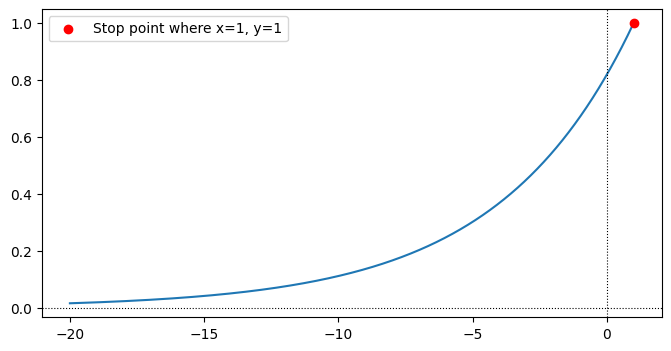

In [15]:
# Define the scale factor
scale_factor = 5  # large scale factor reduces steepness of curve

# Generate x values stopping at x = 1
x = np.linspace(-20, 1, 5000)  # Range of x values from -10 to 1

# Compute the function values
y = np.exp((x - 1) / scale_factor)

# Plot the function
plt.figure(figsize=(8, 4))
plt.plot(x, y)

# Highlight the stopping point at (1, 1)
plt.scatter(1, 1, color='red', label='Stop point where x=1, y=1', zorder=5)

# Add dotted x and y axes
plt.axhline(0, color='black', linewidth=0.8, linestyle=':')  # Dotted x-axis
plt.axvline(0, color='black', linewidth=0.8, linestyle=':')  # Dotted y-axis

plt.legend(fontsize=10)
plt.show()

In [16]:
# executing log transformation
to_transform = list(magnitude_of_ranges_df.index.drop(['current_address_months_count']))

# the features will be shifted up by the following values before log transformation occurs (if minimum value of a feature is 1 or above, there will be no shift)
feature_shifts = {}
for i in to_transform:
    min_value = min(X_train[i])
    if min_value < 1:
        feature_shifts[i] = 1 + abs(min_value)
    else:
        feature_shifts[i] = 0

X_train_encoded_transformed = X_train_encoded.copy()
X_test_encoded_transformed = X_test_encoded.copy()

# for edge case transformation of test set
def transform_below_one(x, scale_factor=5):
    return np.exp((x - 1) / scale_factor)

# log transformations 
for i in to_transform:
    # on training set
    X_train_encoded_transformed[i] = np.log(X_train_encoded[i] + feature_shifts[i])

    # on test set using feature shifts defined by training set
    if feature_shifts[i] == 0:
        test_pre_log = list(map(lambda x: transform_below_one(x, 5) if x <= 0 else x, X_test_encoded[i]))
    else:
        test_pre_log = X_test_encoded[i] + feature_shifts[i]
        test_pre_log = list(map(lambda x: transform_below_one(x, 5) if x < 1 else x, test_pre_log))
    X_test_encoded_transformed[i] = np.log(test_pre_log)

In [17]:
X_train[to_transform]

,zip_count_4w,bank_branch_count_8w,intended_balcon_amount,session_length_in_minutes,days_since_request
760648,718,9,-0.810577,8.906903,0.022779
79333,923,1,-1.416575,6.791985,0.027388
771344,1480,6,48.983949,4.689416,0.018037
179102,938,16,-0.844309,11.227696,0.004834
75318,1653,0,52.410502,4.309028,0.011968
...,...,...,...,...,...
963395,2097,2,49.874242,1.813194,0.004316
117952,1762,12,12.828529,9.506439,0.008571
435829,1301,1,-0.294296,5.243137,0.003374
305711,672,2,35.793431,4.447468,1.265285


In [18]:
X_train_encoded_transformed[to_transform]


,zip_count_4w,bank_branch_count_8w,intended_balcon_amount,session_length_in_minutes,days_since_request
0,6.576470,2.302585,2.754932,2.293320,0.022524
1,6.827629,0.693147,2.715620,2.053208,0.027020
2,7.299797,1.945910,4.182272,1.738761,0.017876
3,6.843750,2.833213,2.752784,2.503775,0.004822
4,7.410347,0.000000,4.233252,1.669573,0.011897
...,...,...,...,...,...
799995,7.648263,1.098612,4.195769,1.034630,0.004307
799996,7.474205,2.564949,3.379602,2.352071,0.008535
799997,7.170888,0.693147,2.787247,1.831622,0.003368
799998,6.510258,1.098612,3.957455,1.695311,0.817701


In [19]:
# compare skewness after transformation
features = []
skews = []
for i in to_transform:
        features.append(i)
        skews.append(skew(X_train_encoded_transformed[i]))
skews_df = pd.DataFrame({'Feature':features, 'Skewness_After':skews}).set_index('Feature')
magnitude_of_ranges_df.join(skews_df, on='Feature', how='inner').drop('range_orders_of_magnitude', axis=1).rename(columns={'Skewness':'Skewness_Before'})

,Skewness_Before,Skewness_After
Feature,,
zip_count_4w,1.454840,-0.358178
bank_branch_count_8w,2.746926,0.921697
intended_balcon_amount,2.505943,1.567151
session_length_in_minutes,3.315531,0.489976
days_since_request,9.278334,3.827958


## <u>Scaling for numerical features</u>

In [20]:
# apply robust scaling
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

# select features for scaling
numericals = data_types['numerical_continuous_bounded']+data_types['numerical_continuous_unbounded']+data_types['numerical_discrete']+data_types['ordinal']+data_types['temporal']
to_drop = ['prev_address_months_count', 'bank_months_count'] # variables not used anymore
to_scale = [i for i in numericals if i not in to_drop]

# Scale all numerical features in both train and test sets
X_train_encoded_transformed_scaled = X_train_encoded_transformed.copy()
X_test_encoded_transformed_scaled = X_test_encoded_transformed.copy()

X_train_encoded_transformed_scaled[to_scale] = scaler.fit_transform(X_train_encoded_transformed[to_scale])
X_test_encoded_transformed_scaled[to_scale] = scaler.transform(X_test_encoded_transformed[to_scale])

In [21]:
X_train_encoded_transformed[to_scale]

,name_email_similarity,days_since_request,intended_balcon_amount,velocity_6h,velocity_24h,velocity_4w,session_length_in_minutes,current_address_months_count,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,zip_count_4w,income,customer_age,month
0,0.192523,0.022524,2.754932,3784.358473,2912.626248,4206.784786,2.293320,54,2.302585,10,137,6.576470,0.1,20,5
1,0.238720,0.027020,2.715620,9712.032941,4863.710966,6384.777776,2.053208,47,0.693147,5,50,6.827629,0.9,40,0
2,0.204426,0.017876,4.182272,2765.174801,5248.159541,4237.976176,1.738761,92,1.945910,14,123,7.299797,0.8,30,5
3,0.904621,0.004822,2.752784,6147.912418,4278.845661,5455.794500,2.503775,149,2.833213,8,191,6.843750,0.6,40,1
4,0.521190,0.011897,4.233252,3098.367323,5289.339754,6455.672584,1.669573,44,0.000000,14,163,7.410347,0.6,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,0.615751,0.004307,4.195769,4359.403360,2741.768532,6433.794944,1.034630,43,1.098612,15,109,7.648263,0.7,40,7
799996,0.789709,0.008535,3.379602,6920.945581,6972.470268,5870.108156,2.352071,36,2.564949,10,189,7.474205,0.4,20,0
799997,0.405628,0.003368,2.787247,750.357870,2989.495690,4991.307731,1.831622,13,0.693147,8,219,7.170888,0.7,50,3
799998,0.591697,0.817701,3.957455,12353.087248,7375.660608,5359.857894,1.695311,50,1.098612,6,96,6.510258,0.4,50,2


In [22]:
X_train_encoded_transformed_scaled[to_scale]

,name_email_similarity,days_since_request,intended_balcon_amount,velocity_6h,velocity_24h,velocity_4w,session_length_in_minutes,current_address_months_count,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,zip_count_4w,income,customer_age,month
0,-0.565514,0.396382,0.003624,-0.361720,-0.851356,-0.579527,0.551815,0.009091,0.000000,0.142857,0.157895,-0.727622,-1.0,-0.5,0.50
1,-0.478354,0.635447,-0.111367,1.035227,0.052407,1.205380,0.276370,-0.054545,-0.627474,-0.571429,-0.757895,-0.404043,0.6,0.5,-0.75
2,-0.543056,0.149222,4.178700,-0.601906,0.230488,-0.553965,-0.084347,0.354545,-0.139057,0.714286,0.010526,0.204269,0.4,0.0,0.50
3,0.778020,-0.544947,-0.002659,0.195288,-0.218509,0.444060,0.793238,0.872727,0.206877,-0.142857,0.726316,-0.383274,0.0,0.5,-0.50
4,0.054590,-0.168742,4.327822,-0.523385,0.249563,1.263479,-0.163716,-0.081818,-0.897712,0.714286,0.431579,0.346694,0.0,0.0,-0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,0.233001,-0.572366,4.218182,-0.226202,-0.930499,1.245550,-0.892090,-0.090909,-0.469394,0.857143,-0.136842,0.653211,0.2,0.5,1.00
799996,0.561213,-0.347524,1.830831,0.377465,1.029207,0.783598,0.619211,-0.154545,0.102288,0.142857,0.705263,0.428965,-0.4,-0.5,-0.75
799997,-0.163442,-0.622273,0.098147,-1.076729,-0.815749,0.063404,0.022179,-0.363636,-0.627474,-0.142857,1.021053,0.038191,0.2,1.0,0.00
799998,0.187617,42.681724,3.521094,1.657633,1.215969,0.365438,-0.134191,-0.027273,-0.469394,-0.428571,-0.273684,-0.812925,-0.4,1.0,-0.25


## <u>Handling class imbalance</u>

In [23]:
# define nominal and continuous variables
numericals = data_types['numerical_continuous_bounded']+data_types['numerical_continuous_unbounded']+data_types['numerical_discrete']+data_types['ordinal']
to_drop = ['prev_address_months_count', 'bank_months_count'] # variables not used anymore
numericals = [i for i in numericals if i not in to_drop]
nominals = [i for i in X_train_encoded_transformed_scaled.columns if i not in numericals]

# specify categorical feature indices
categorical_columns_idx = [X_train_encoded_transformed_scaled.columns.get_loc(i) for i in nominals]

# apply smote nc (to handle nominal and categorical variables)
smote_nc = SMOTENC(categorical_features=categorical_columns_idx, sampling_strategy=1, random_state=0)
X_train_encoded_transformed_scaled_resampled, y_train_resampled = smote_nc.fit_resample(X_train_encoded_transformed_scaled, y_train)

In [24]:
y_train_resampled.value_counts()

fraud_bool
0    791170
1    791170
Name: count, dtype: int64

In [25]:
X_train

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month,source_is_internet_not_teleapp,bank_months_count_provided,prev_address_months_count_provided,current_address_months_count_provided
760648,0.1,0.192523,54,20,0.022779,-0.810577,AB,718,3784.358473,2912.626248,4206.784786,9,10,CD,137,0,BB,0,1,0,200.0,0,8.906903,other,1,1,5,1,1,0,1
79333,0.9,0.238720,47,40,0.027388,-1.416575,AC,923,9712.032941,4863.710966,6384.777776,1,5,CA,50,1,BC,0,1,0,200.0,0,6.791985,windows,1,1,0,1,0,0,1
771344,0.8,0.204426,92,30,0.018037,48.983949,AA,1480,2765.174801,5248.159541,4237.976176,6,14,CA,123,0,BA,0,1,0,200.0,0,4.689416,linux,0,1,5,1,1,0,1
179102,0.6,0.904621,149,40,0.004834,-0.844309,AB,938,6147.912418,4278.845661,5455.794500,16,8,CA,191,1,BE,1,1,0,other,0,11.227696,linux,1,1,1,1,1,0,1
75318,0.6,0.521190,44,30,0.011968,52.410502,AA,1653,3098.367323,5289.339754,6455.672584,0,14,CA,163,1,BE,1,1,0,1000.0,0,4.309028,linux,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963395,0.7,0.615751,43,40,0.004316,49.874242,AA,2097,4359.403360,2741.768532,6433.794944,2,15,CA,109,0,BD,1,1,0,200.0,0,1.813194,other,1,1,7,1,1,0,1
117952,0.4,0.789709,36,20,0.008571,12.828529,AA,1762,6920.945581,6972.470268,5870.108156,12,10,CA,189,0,BC,0,1,0,1500.0,0,9.506439,other,1,1,0,1,1,0,1
435829,0.7,0.405628,13,50,0.003374,-0.294296,AC,1301,750.357870,2989.495690,4991.307731,1,8,CA,219,1,BB,0,1,0,other,0,5.243137,other,0,1,3,1,0,0,1
305711,0.4,0.591697,50,50,1.265285,35.793431,AA,672,12353.087248,7375.660608,5359.857894,2,6,CA,96,0,BC,0,1,0,200.0,0,4.447468,other,0,1,2,1,1,0,1


In [26]:
X_train_encoded

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,source_is_internet_not_teleapp,bank_months_count_provided,prev_address_months_count_provided,current_address_months_count_provided,proposed_credit_limit_1500.0,proposed_credit_limit_200.0,proposed_credit_limit_500.0,proposed_credit_limit_other,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.1,0.192523,54,20,0.022779,-0.810577,718,3784.358473,2912.626248,4206.784786,9,10,137,0,0,1,0,0,8.906903,1,1,5,1,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.9,0.238720,47,40,0.027388,-1.416575,923,9712.032941,4863.710966,6384.777776,1,5,50,1,0,1,0,0,6.791985,1,1,0,1,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.8,0.204426,92,30,0.018037,48.983949,1480,2765.174801,5248.159541,4237.976176,6,14,123,0,0,1,0,0,4.689416,0,1,5,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.6,0.904621,149,40,0.004834,-0.844309,938,6147.912418,4278.845661,5455.794500,16,8,191,1,1,1,0,0,11.227696,1,1,1,1,1,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.6,0.521190,44,30,0.011968,52.410502,1653,3098.367323,5289.339754,6455.672584,0,14,163,1,1,1,0,0,4.309028,1,1,0,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,0.7,0.615751,43,40,0.004316,49.874242,2097,4359.403360,2741.768532,6433.794944,2,15,109,0,1,1,0,0,1.813194,1,1,7,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799996,0.4,0.789709,36,20,0.008571,12.828529,1762,6920.945581,6972.470268,5870.108156,12,10,189,0,0,1,0,0,9.506439,1,1,0,1,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799997,0.7,0.405628,13,50,0.003374,-0.294296,1301,750.357870,2989.495690,4991.307731,1,8,219,1,0,1,0,0,5.243137,0,1,3,1,0,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799998,0.4,0.591697,50,50,1.265285,35.793431,672,12353.087248,7375.660608,5359.857894,2,6,96,0,0,1,0,0,4.447468,0,1,2,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [27]:
X_train_encoded_transformed

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,source_is_internet_not_teleapp,bank_months_count_provided,prev_address_months_count_provided,current_address_months_count_provided,proposed_credit_limit_1500.0,proposed_credit_limit_200.0,proposed_credit_limit_500.0,proposed_credit_limit_other,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0.1,0.192523,54,20,0.022524,2.754932,6.576470,3784.358473,2912.626248,4206.784786,2.302585,10,137,0,0,1,0,0,2.293320,1,1,5,1,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.9,0.238720,47,40,0.027020,2.715620,6.827629,9712.032941,4863.710966,6384.777776,0.693147,5,50,1,0,1,0,0,2.053208,1,1,0,1,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.8,0.204426,92,30,0.017876,4.182272,7.299797,2765.174801,5248.159541,4237.976176,1.945910,14,123,0,0,1,0,0,1.738761,0,1,5,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.6,0.904621,149,40,0.004822,2.752784,6.843750,6147.912418,4278.845661,5455.794500,2.833213,8,191,1,1,1,0,0,2.503775,1,1,1,1,1,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.6,0.521190,44,30,0.011897,4.233252,7.410347,3098.367323,5289.339754,6455.672584,0.000000,14,163,1,1,1,0,0,1.669573,1,1,0,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,0.7,0.615751,43,40,0.004307,4.195769,7.648263,4359.403360,2741.768532,6433.794944,1.098612,15,109,0,1,1,0,0,1.034630,1,1,7,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799996,0.4,0.789709,36,20,0.008535,3.379602,7.474205,6920.945581,6972.470268,5870.108156,2.564949,10,189,0,0,1,0,0,2.352071,1,1,0,1,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799997,0.7,0.405628,13,50,0.003368,2.787247,7.170888,750.357870,2989.495690,4991.307731,0.693147,8,219,1,0,1,0,0,1.831622,0,1,3,1,0,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799998,0.4,0.591697,50,50,0.817701,3.957455,6.510258,12353.087248,7375.660608,5359.857894,1.098612,6,96,0,0,1,0,0,1.695311,0,1,2,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
X_train_encoded_transformed_scaled

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,source_is_internet_not_teleapp,bank_months_count_provided,prev_address_months_count_provided,current_address_months_count_provided,proposed_credit_limit_1500.0,proposed_credit_limit_200.0,proposed_credit_limit_500.0,proposed_credit_limit_other,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,-1.0,-0.565514,0.009091,-0.5,0.396382,0.003624,-0.727622,-0.361720,-0.851356,-0.579527,0.000000,0.142857,0.157895,0,0,1,0,0,0.551815,1,1,0.50,1,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.6,-0.478354,-0.054545,0.5,0.635447,-0.111367,-0.404043,1.035227,0.052407,1.205380,-0.627474,-0.571429,-0.757895,1,0,1,0,0,0.276370,1,1,-0.75,1,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.4,-0.543056,0.354545,0.0,0.149222,4.178700,0.204269,-0.601906,0.230488,-0.553965,-0.139057,0.714286,0.010526,0,0,1,0,0,-0.084347,0,1,0.50,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.778020,0.872727,0.5,-0.544947,-0.002659,-0.383274,0.195288,-0.218509,0.444060,0.206877,-0.142857,0.726316,1,1,1,0,0,0.793238,1,1,-0.50,1,1,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.054590,-0.081818,0.0,-0.168742,4.327822,0.346694,-0.523385,0.249563,1.263479,-0.897712,0.714286,0.431579,1,1,1,0,0,-0.163716,1,1,-0.75,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,0.2,0.233001,-0.090909,0.5,-0.572366,4.218182,0.653211,-0.226202,-0.930499,1.245550,-0.469394,0.857143,-0.136842,0,1,1,0,0,-0.892090,1,1,1.00,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799996,-0.4,0.561213,-0.154545,-0.5,-0.347524,1.830831,0.428965,0.377465,1.029207,0.783598,0.102288,0.142857,0.705263,0,0,1,0,0,0.619211,1,1,-0.75,1,1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799997,0.2,-0.163442,-0.363636,1.0,-0.622273,0.098147,0.038191,-1.076729,-0.815749,0.063404,-0.627474,-0.142857,1.021053,1,0,1,0,0,0.022179,0,1,0.00,1,0,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
799998,-0.4,0.187617,-0.027273,1.0,42.681724,3.521094,-0.812925,1.657633,1.215969,0.365438,-0.469394,-0.428571,-0.273684,0,0,1,0,0,-0.134191,0,1,-0.25,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [29]:
X_train_encoded_transformed_scaled_resampled

,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,month,source_is_internet_not_teleapp,bank_months_count_provided,prev_address_months_count_provided,current_address_months_count_provided,proposed_credit_limit_1500.0,proposed_credit_limit_200.0,proposed_credit_limit_500.0,proposed_credit_limit_other,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,-1.000000,-0.565514,0.009091,-0.500000,0.396382,0.003624,-0.727622,-0.361720,-0.851356,-0.579527,0.000000,0.142857,0.157895,0,0,1,0,0,0.551815,1,1,0.50,1,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.600000,-0.478354,-0.054545,0.500000,0.635447,-0.111367,-0.404043,1.035227,0.052407,1.205380,-0.627474,-0.571429,-0.757895,1,0,1,0,0,0.276370,1,1,-0.75,1,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.400000,-0.543056,0.354545,0.000000,0.149222,4.178700,0.204269,-0.601906,0.230488,-0.553965,-0.139057,0.714286,0.010526,0,0,1,0,0,-0.084347,0,1,0.50,1,1,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.778020,0.872727,0.500000,-0.544947,-0.002659,-0.383274,0.195288,-0.218509,0.444060,0.206877,-0.142857,0.726316,1,1,1,0,0,0.793238,1,1,-0.50,1,1,0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.054590,-0.081818,0.000000,-0.168742,4.327822,0.346694,-0.523385,0.249563,1.263479,-0.897712,0.714286,0.431579,1,1,1,0,0,-0.163716,1,1,-0.75,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582335,0.600000,-0.437827,0.640974,1.250273,-0.369974,0.018630,-0.511983,-0.553749,-0.626384,-0.394402,0.193581,-0.285403,0.789393,1,0,1,0,0,-0.165128,0,1,0.75,1,1,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1582336,0.600000,-0.536838,0.209881,0.664253,-0.057155,2.891812,-0.503648,0.423338,0.359462,-0.603736,0.944869,-0.332644,0.653089,1,0,1,0,0,1.326930,0,1,0.75,1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1582337,0.600000,-0.053133,-0.103562,0.500000,-0.464800,0.010521,-1.365406,-0.512238,-0.897061,-1.466540,0.096357,-0.589838,0.846390,0,0,1,0,0,-0.150845,0,1,1.00,1,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1582338,0.397068,-0.776790,0.223674,1.000000,-0.617857,-0.057626,0.122552,0.178523,0.165853,0.097056,0.423788,-1.000000,-0.272388,1,1,0,0,0,-0.834498,1,1,0.50,1,1,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## <u>Export datasets</u>

In [35]:
import os
data_folder = os.path.join(os.getcwd(), 'data')

# X_train
file_path = os.path.join(data_folder, 'X_train_encoded_transformed_scaled_resampled.csv')
X_train_encoded_transformed_scaled_resampled.to_csv(file_path, index=False)

# X_test
file_path = os.path.join(data_folder, 'X_test_encoded_transformed_scaled.csv')
X_test_encoded_transformed_scaled.to_csv(file_path, index=False)

# y_train
file_path = os.path.join(data_folder, 'y_train_resampled.csv')
y_train_resampled.to_csv(file_path, index=False)

# y_test
file_path = os.path.join(data_folder, 'y_test.csv')
y_test.to_csv(file_path, index=False)